In [1]:
#Import loading libraries
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import math

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as sp_train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as sp_train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD


### Dataset Download

In [2]:
# === 1.Dataset Download ===


if not os.path.exists('ml-100k'):
    url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
    print("Downloading MovieLens 100K…")
    urllib.request.urlretrieve(url, 'ml-100k.zip')
    print("Extracting…")
    with zipfile.ZipFile('ml-100k.zip', 'r') as z:
        z.extractall()
    print("Done!")

# === 2. Load & Preprocess Data ===
# 2.1 Ratings: user_id, movie_id, rating, timestamp
ratings = pd.read_csv(
    'ml-100k/u.data',
    sep='\t',
    names=['user_id','movie_id','rating','ts']
)



In [3]:

# === 3. Load and Decode Movie Metadata ===
genre_list = pd.read_csv('ml-100k/u.genre', sep='|', header=None, usecols=[0]).iloc[:, 0].tolist()
items = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1')
items = items[[0, 1] + list(range(5, 5 + len(genre_list)))]
items.columns = ['movie_id', 'title'] + genre_list

def decode_genres(row):
    flags = row[genre_list].values
    return ' '.join([g for g, f in zip(genre_list, flags) if f == 1])

items['genre_str'] = items.apply(decode_genres, axis=1)
movies = items[['movie_id', 'title', 'genre_str']]

## Exploratory Data Analysis

In [4]:

def perform_eda(ratings):
    import matplotlib.pyplot as plt
    import seaborn as sns

    print("✅ Dataset Overview")
    print("Ratings dataset shape:", ratings.shape)
    print("Number of unique users:", ratings['user_id'].nunique())
    print("Number of unique movies:", ratings['movie_id'].nunique())
    print("Total ratings:", len(ratings))

    # 1. Rating distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='rating', data=ratings)
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()
    print("Insight: Ratings are skewed towards higher scores (e.g., 4 & 5), indicating positive bias.")

    # 2. Number of ratings per user
    user_freq = ratings['user_id'].value_counts()
    plt.figure(figsize=(6, 4))
    sns.histplot(user_freq, bins=30, kde=True)
    plt.title('Ratings per User')
    plt.xlabel('Ratings Count')
    plt.ylabel('User Frequency')
    plt.show()
    print("Insight: Most users have rated fewer than 100 movies. Power users are rare.")

    # 3. Number of ratings per movie
    movie_freq = ratings['movie_id'].value_counts()
    plt.figure(figsize=(6, 4))
    sns.histplot(movie_freq, bins=30, kde=True)
    plt.title('Ratings per Movie')
    plt.xlabel('Ratings Count')
    plt.ylabel('Movie Frequency')
    plt.show()
    print("Insight: A small number of movies have received most ratings (popularity bias).")

    # 4. Dataset sparsity
    num_users = ratings['user_id'].nunique()
    num_movies = ratings['movie_id'].nunique()
    sparsity = 1.0 - len(ratings) / float(num_users * num_movies)
    print(f"Sparsity of the user-movie matrix: {sparsity:.4f}")
    print("Insight: High sparsity is expected in recommender systems, requiring robust models.")


✅ Dataset Overview
Ratings dataset shape: (100000, 4)
Number of unique users: 943
Number of unique movies: 1682
Total ratings: 100000


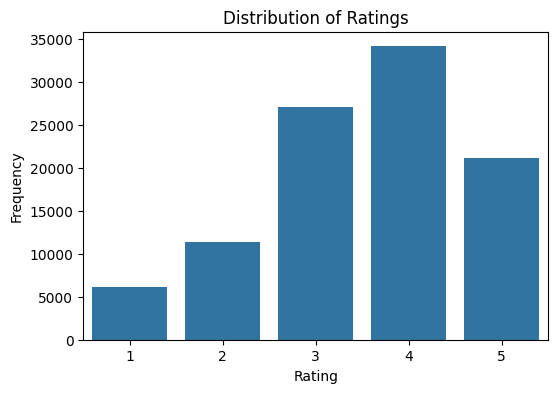

Insight: Ratings are skewed towards higher scores (e.g., 4 & 5), indicating positive bias.


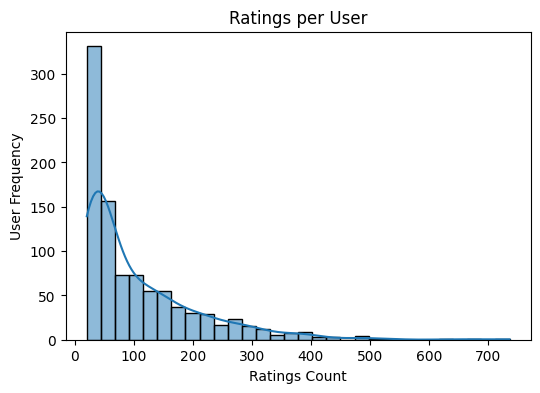

Insight: Most users have rated fewer than 100 movies. Power users are rare.


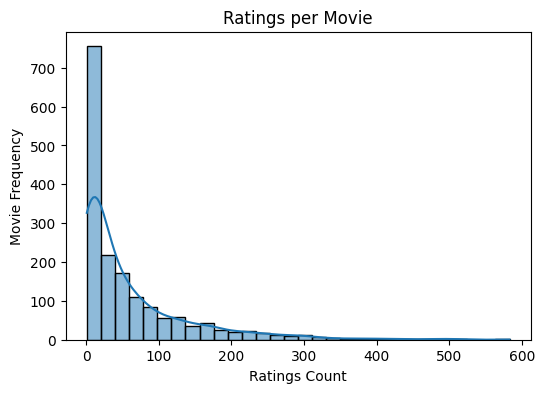

Insight: A small number of movies have received most ratings (popularity bias).
Sparsity of the user-movie matrix: 0.9370
Insight: High sparsity is expected in recommender systems, requiring robust models.


In [5]:
perform_eda(ratings)

## Train/Test Data Split

In [6]:
# === 3. Train/Test Split ===
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id','movie_id','rating']], reader)
cf_trainset, cf_valset = sp_train_test_split(data, test_size=0.2, random_state=42)

# Pandas splits for evaluation
train_df = ratings.sample(frac=0.8, random_state=42)
test_df  = ratings.drop(train_df.index)

all_movie_ids = movies['movie_id'].tolist()



## Collaborative Filtering (SVD)

In [7]:

# === 5. Prepare Data for Surprise ===
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

In [8]:
# === 4. Collaborative Filtering (SVD) ===
algo = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.1, random_state=42)
algo.fit(cf_trainset)

def cf_scores(user_id):
    """Predict score for every movie for this user."""
    preds = [algo.predict(user_id, mid).est for mid in all_movie_ids]
    return dict(zip(all_movie_ids, preds))



## Content‑Based

In [9]:
# === 5. Content‑Based (TF‑IDF on Genres) ===
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genre_str'])
idx_map = {mid: idx for idx, mid in enumerate(movies['movie_id'])}

def content_scores_for_user(user_id):
    """Build user profile from high‑rated items and compute similarities."""
    liked = train_df[(train_df.user_id==user_id) & (train_df.rating>=4)]['movie_id']
    if liked.empty:
        return {mid: 0.0 for mid in all_movie_ids}
    # average the TF-IDF vectors of liked movies
    user_vec = tfidf_matrix[[idx_map[mid] for mid in liked]].mean(axis=0)
    # convert to 2D numpy array (linear_kernel doesn't accept np.matrix)
    if hasattr(user_vec, "toarray"):
        user_vec = user_vec.toarray()
    else:
        user_vec = np.asarray(user_vec)
    user_vec = user_vec.reshape(1, -1)
    sims = linear_kernel(user_vec, tfidf_matrix).flatten()
    return dict(zip(all_movie_ids, sims))



## Popularity Fallback

In [10]:
# === 6. Popularity Fallback ===
popularity = train_df['movie_id'].value_counts()
popular_items = popularity.index.tolist()



## Hybrid Recommendation with Cold‑Start & Fallback

In [11]:
# === 7. Hybrid Recommendation with Cold‑Start & Fallback ===
def hybrid_recommend(user_id, K=10, alpha=0.7):
    user_hist = train_df[train_df.user_id == user_id]
    # Cold‑start user: no history
    if user_hist.empty:
        return popular_items[:K]
    # No strong likes: fallback to popular
    if user_hist[user_hist.rating >= 4].empty:
        return popular_items[:K]
    # Compute CF & CB
    cf = cf_scores(user_id)
    cb = content_scores_for_user(user_id)
    # Hybrid score
    scores = {mid: alpha * cf[mid] + (1-alpha) * cb[mid]
              for mid in all_movie_ids}
    return sorted(scores, key=scores.get, reverse=True)[:K]



## Evaluation Metrics

In [12]:
# === 8. Evaluation Metrics ===
def precision_at_k(recs, true_items, K):
    return len(set(recs[:K]) & set(true_items)) / K

def dcg(recs, true_set, K):
    return sum((1/math.log2(i+2)) for i,m in enumerate(recs[:K]) if m in true_set)

def ndcg_at_k(recs, true_items, K):
    ideal = dcg(list(true_items), set(true_items), K)
    return dcg(recs, set(true_items), K) / ideal if ideal > 0 else 0

def evaluate(model_fn, users, K=10):
    precs, ndcgs = [], []
    for u in users:
        true = test_df[test_df.user_id==u]['movie_id'].tolist()
        if not true:
            continue
        recs = model_fn(u, K=K)
        precs.append(precision_at_k(recs, true, K))
        ndcgs.append(ndcg_at_k(recs, true, K))
    return np.mean(precs), np.mean(ndcgs)




## Run Evaluation

In [13]:
# === 9. Run Evaluation ===
np.random.seed(42)
sample_users = np.random.choice(test_df.user_id.unique(), size=300, replace=False)
prec, ndcg = evaluate(hybrid_recommend, sample_users, K=10)
print(f'Hybrid Precision@10: {prec:.4f}, NDCG@10: {ndcg:.4f}')

Hybrid Precision@10: 0.0463, NDCG@10: 0.0501


In [14]:
# === Show Top 10 Recommendations for a Known User ===
known_user_id = sample_users[0]  # pick a test user
print(f"Top 10 recommendations for known user {known_user_id}:")
recommended_movie_ids = hybrid_recommend(known_user_id, K=10)
print(movies.set_index('movie_id').loc[recommended_movie_ids][['title']])


Top 10 recommendations for known user 643:
                                     title
movie_id                                  
408                  Close Shave, A (1995)
64        Shawshank Redemption, The (1994)
169             Wrong Trousers, The (1993)
483                      Casablanca (1942)
318                Schindler's List (1993)
178                    12 Angry Men (1957)
480              North by Northwest (1959)
513                  Third Man, The (1949)
603                     Rear Window (1954)
50                        Star Wars (1977)


In [15]:
# === Show Top 10 Recommendations for a Cold-Start User ===
print("Top 10 recommendations for a new/unknown user (cold-start):")
cold_user_recommendations = hybrid_recommend(user_id=999999, K=10)  # ID not in train set
print(movies.set_index('movie_id').loc[cold_user_recommendations][['title']])


Top 10 recommendations for a new/unknown user (cold-start):
                                  title
movie_id                               
50                     Star Wars (1977)
181           Return of the Jedi (1983)
258                      Contact (1997)
100                        Fargo (1996)
294                    Liar Liar (1997)
286         English Patient, The (1996)
288                       Scream (1996)
1                      Toy Story (1995)
121       Independence Day (ID4) (1996)
300                Air Force One (1997)


In [16]:
# Scalability Considerations (Documentation)
print("""
Scalability:
- Use Approximate Nearest Neighbor (ANN) techniques like FAISS or Annoy for efficient retrieval.
- Distributed Collaborative Filtering model training using Spark MLlib or GPU-accelerated methods.
- Cache frequently accessed results using Redis.
- Implement microservices architecture to separate recommendation tasks for better scalability.
- Use feature store (e.g., Feast) for efficient batch pipeline management and rapid online inference.
""")


Scalability:
- Use Approximate Nearest Neighbor (ANN) techniques like FAISS or Annoy for efficient retrieval.
- Distributed Collaborative Filtering model training using Spark MLlib or GPU-accelerated methods.
- Cache frequently accessed results using Redis.
- Implement microservices architecture to separate recommendation tasks for better scalability.
- Use feature store (e.g., Feast) for efficient batch pipeline management and rapid online inference.

